# 1-Retrieve data

import necesaary libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
from agrid.grid import Grid
from pathlib import Path

import os, sys, pickle

from pathlib import Path

import pandas as pd

import re
import copy

import numpy as np
from numpy import asarray
from numpy import save
from numpy import load

from scipy import stats, interpolate, spatial, io
from scipy.ndimage import gaussian_filter, median_filter
import xarray as xr
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.patches import Arc 
import cartopy.crs as ccrs

import pyproj as proj
import rasterio


from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error

import seaborn as sns

from joblib import Parallel, delayed
import multiprocessing
import numba as nb
from numba import jit

import warnings
warnings.filterwarnings('ignore')


import numpy as np
from scipy.spatial import cKDTree as KDTree


from matplotlib.patches import Rectangle

In [3]:
# constanst

#parent directory

dir_p = Path().resolve() 

#constants
km = 1000
milli = 0.001
micro = 0.000001

# fig size for presentation
fig_pres_small = (4,3)

fig_pres_small_cbar = (4,2)
#aspect ratio
fig_pres_large = (16,9)



# We can exclude Arctic ocean and Antarctica, as there are no HF measurements to use
world_lon_min, world_lon_max, world_lat_min, world_lat_max  = -180, 180, -60, 80

# map extents of Africa and Australia
afr_lon_min, afr_lon_max, afr_lat_min, afr_lat_max =  -20, 52, -37 , 38  


# create grid for each region
# crs Coordinate reference system

#EPSG is projection
# 0.2 degrees equal roughly 20 km

World = Grid(res=[0.2, 0.2], up=world_lat_max, down=world_lat_min)

# africa grid

Africa =    Grid(res=[0.2, 0.2],  left = afr_lon_min, right= afr_lon_max, up=afr_lat_max , down=afr_lat_min)

# africa grid low resolution 50 x 50 km

Africa_50 =    Grid(res=[0.5, 0.5],  left = afr_lon_min, right= afr_lon_max, up=afr_lat_max , down=afr_lat_min)


#dictionary of all grids

grids = {}

grids['Afr'] = Africa
grids['Afr_50'] = Africa_50
grids['World'] = World


In [4]:
# to ease looping with dictionaries

regions_a_a5 = [ 'Afr','Afr_50' ]

regions_w_a = [ 'World' ,'Afr',]
regions_w_aus = [ 'World' ,'Aus',]


regions_w_a_a5 = [ 'World' ,'Afr', 'Afr_50']


regions_Total = ['World' ,'Afr', 'Afr_50',]


# raster exenets to adjust map
raster_extent_Afr = [grids['Afr'].extent[0], grids['Afr'].extent[1], grids['Afr'].extent[3], grids['Afr'].extent[2]]
raster_extent_Afr_50 = [grids['Afr_50'].extent[0], grids['Afr_50'].extent[1], grids['Afr_50'].extent[3], grids['Afr_50'].extent[2]]
raster_extent_World = [grids['World'].extent[0], grids['World'].extent[1], grids['World'].extent[3], grids['World'].extent[2]]

# to correct plot maps
raster_extents = {}

raster_extents['Afr'] = raster_extent_Afr
raster_extents['Afr_50'] = raster_extent_Afr_50
raster_extents['World'] = raster_extent_World


# list of latitudes and longitudes
lon_dict = {}
lat_dict = {}

lon_dict['Afr'] = [afr_lon_min, afr_lon_max]
lon_dict['Afr_50'] = [afr_lon_min, afr_lon_max]
lon_dict['World'] = [world_lon_min, world_lon_max]

lat_dict['Afr'] = [afr_lat_min, afr_lat_max]
lat_dict['Afr_50'] = [afr_lat_min, afr_lat_max]
lat_dict['World'] = [world_lat_min, world_lat_max]


print('terminated')

terminated


In [5]:
obs = pd.DataFrame()


''' 
obs['REF_n'] = [ 'MOHO','LAB', 'RHO_C', 'SV', 'PV', 'CTD',
             'RHO_L', 'DEM', 
                'VOLC_DIST_W', 'A_MEDIAN_W', 'FA', 'SI','LITH_MANTLE', 
                'EMAG2_CLASS', 'GEOID', 'BG',
              'GLIM']'''



obs['OBS_REF_IDW'] = ['CTD_IDW' ,  'SI_IDW',"LAB_IDW", "MOHO_IDW",
            "SV_IDW","PV_IDW", 
            'GEOID_IDW','FA_IDW','DEM','BG_IDW', 'EMAG2_CLASS',
                   'RHO_L_IDW', 'RHO_C_IDW', 
                  'VOLC_DIST_W', 'REG', 'GLIM']



obs['OBS_REF_LN'] = ['CTD_LN' ,  'SI_LN',"LAB_LN", "MOHO_LN",
            "SV_LN","PV_LN", 
            'GEOID_LN','FA_LN','DEM','BG_LN', 'EMAG2_CLASS',
                  'RHO_L_LN', 'RHO_C_LN', 
                      'VOLC_DIST_W', 'REG', 'GLIM']
  
     
# Labels for plots etc
obs['LABELS'] = ['CTD',  'Shape index', 'LAB depth', 'Moho depth', 
                'S$_V$ 150km', 'P$_V$ 150km', 
                'Geoid', 'Free air', 'DEM', 'Bouguer', 'Mag.', 
                'Lith. ρ', 'Crust ρ',  
                 'Volcano d.', 'GliM', 'REG', ]  
    
    
# 'vp/vs'
# Units to display in plots etc
obs['UNITS'] = ['km',  'si', 'km', 'km',
             '$\delta$ v_s %','$\delta$ v_p %', 
             'm', 'mGal', 'm', 'mGal',  'f(nT)', 
                 'kg/m$^3$', 'kg/m$^3$',
                'km',  'class', 'class']
        
# Range of colormap for plots. Similar data are placed in same ranges for consistancy
obs['V_RANGE'] = [(0,50), (-1,1),(0,300),(15,60),
              (-0.075,0.075), (-0.02,0.02), 
              (-45,45), (-100,100) , (-2200, 2200),(-100,100),  (-0.4, 0.4), 
                   (3260, 3360), (2650, 2950),
                  (0,1), (1,6),(1,15),]
    
obs["CMAPS"] = ["batlow",  "broc", "bamako", "batlow", 
             "roma","roma", 
             "bamako", "broc", "bukavu", "broc", "batlow",            
                "batlow", "batlow",
               "bamako",  "batlowS","topo", ]

#new_index = [4,3,15,6,7,0,14,10,16,17,9, 2,1,5,13,12, 8,11,]

#new_index = [4,3,15,6,7,0, 14, 10,16, 8, 9,2, 13, 12, 8, 11, ]

#obs = obs.reindex(new_index)

obs.index = np.arange(0,len(obs))

pd.options.display.width = 370
pd.options.display.max_colwidth = 12
print(obs)

n_obs = len(obs)

obs_dict = obs.to_dict(orient='records')



    OBS_REF_IDW   OBS_REF_LN       LABELS        UNITS      V_RANGE    CMAPS
0       CTD_IDW       CTD_LN          CTD           km      (0, 50)   batlow
1        SI_IDW        SI_LN  Shape index           si      (-1, 1)     broc
2       LAB_IDW       LAB_LN    LAB depth           km     (0, 300)   bamako
3      MOHO_IDW      MOHO_LN   Moho depth           km     (15, 60)   batlow
4        SV_IDW        SV_LN  S$_V$ 150km  $\delta$...  (-0.075,...     roma
5        PV_IDW        PV_LN  P$_V$ 150km  $\delta$...  (-0.02, ...     roma
6     GEOID_IDW     GEOID_LN        Geoid            m    (-45, 45)   bamako
7        FA_IDW        FA_LN     Free air         mGal  (-100, 100)     broc
8           DEM          DEM          DEM            m  (-2200, ...   bukavu
9        BG_IDW        BG_LN      Bouguer         mGal  (-100, 100)     broc
10  EMAG2_CLASS  EMAG2_CLASS         Mag.        f(nT)  (-0.4, 0.4)   batlow
11    RHO_L_IDW     RHO_L_LN      Lith. ρ     kg/m$^3$  (3260, 3...   batlow

In [6]:

target = 'heat-flow (mW/m2)'
coord = ['lon', 'lat']



#######

features_ex = []

features_idw = obs['OBS_REF_IDW'].tolist()
features_ln = obs['OBS_REF_LN'].tolist()


in_features_idw = set(features_idw)
in_features_ln = set(features_ln)

in_features_ln_but_not_in_features_idw = in_features_ln - in_features_idw

features_all = features_idw + list(in_features_ln_but_not_in_features_idw)


features_ex = copy.deepcopy(features_idw)
features_ex.extend(coord)
features_ex.append(target)



features_ex_ln = copy.deepcopy(features_ln)
features_ex_ln.extend(coord)
features_ex_ln.append(target)







# Interpolation from datasets

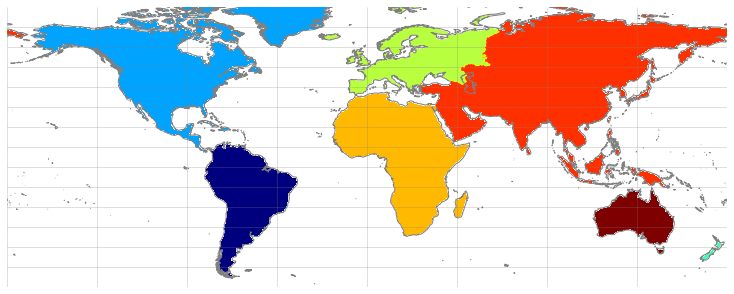

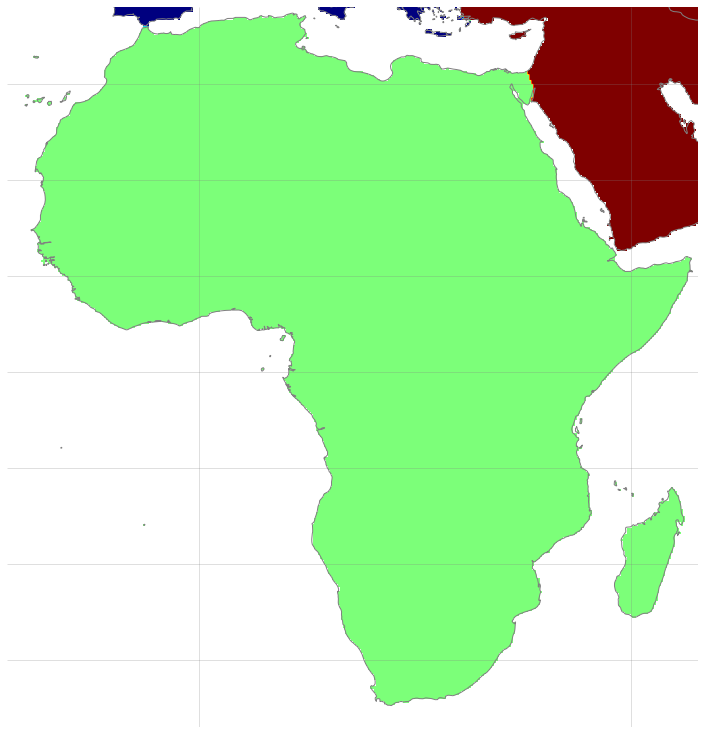

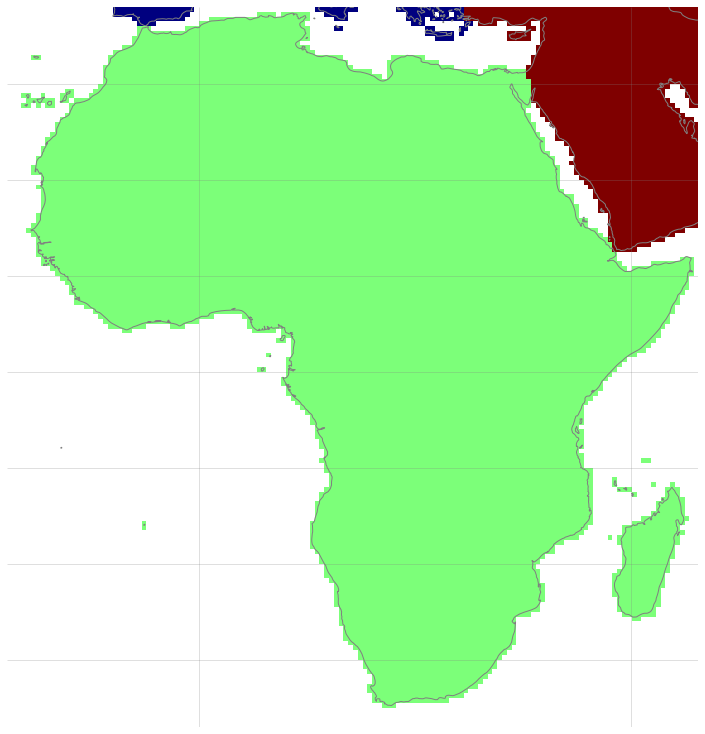

In [7]:
#https://github.com/nvkelso/natural-earth-vector
# natural earth 10 m land shape
ne_10m_land = dir_p / 'data'/ 'Shapefiles'/'NE'/ 'ne_10m_land.shp'
continents = dir_p /'data'/ 'Shapefiles'/'continents'/ 'continent.shp'

# LAND is water vs land
#Continet describes each continent

#assign_shape Rasterize vector polygons to grid 

for region in regions_Total:
    # Use continental plates instead
    grids[region].ds['LAND'] = (('Y', 'X'), grids[region].assign_shape(ne_10m_land, 
                                               'scalerank', map_to_int = False, burn_val = 1))


    grids[region].ds['CONTINENT'] = (('Y', 'X'), grids[region].assign_shape(continents, 
                                               'CONTINENT', map_to_int = True))
    
    
    
    grids[region].map_grid('CONTINENT', raster_extent= raster_extents[region], cmap='jet', figsize=(10,10))

    


# Helper functions

In [8]:
# Haversine arc distance
def distance(lat1, lon1, lat2, lon2):
    '''
    Haversine formula returns distance between pairs of coordinates.
    coordinates as numpy arrays, lists or real
    The haversine formula determines the great-circle distance between 
    two points on a sphere given their longitudes and latitudes
    '''
    p = 0.017453292519943295 # pi/180
    a = 0.5 - np.cos((lat2-lat1)*p)/2 + np.cos(lat1*p)*np.cos(lat2*p) * (1-np.cos((lon2-lon1)*p)) / 2
    return 12742.0176 * np.arcsin(np.sqrt(a)) # returns in km



function to make inverse distance weight interpolation

In [9]:

class Invdisttree:
  
    def __init__( self, X, z, leafsize=10, stat=0 ):
        assert len(X) == len(z), "len(X) %d != len(z) %d" % (len(X), len(z))
        self.tree = KDTree( X, leafsize=leafsize )  # build the tree
        self.z = z
        self.stat = stat
        self.wn = 0
        self.wsum = None;

    def __call__( self, q, nnear=6, eps=0, p=1, weights=None ):
            # nnear nearest neighbours of each query point --
        q = np.asarray(q)
        qdim = q.ndim
        if qdim == 1:
            q = np.array([q])
        if self.wsum is None:
            self.wsum = np.zeros(nnear)

        self.distances, self.ix = self.tree.query( q, k=nnear, eps=eps )
        interpol = np.zeros( (len(self.distances),) + np.shape(self.z[0]) )
        jinterpol = 0
        for dist, ix in zip( self.distances, self.ix ):
            if nnear == 1:
                wz = self.z[ix]
            elif dist[0] < 1e-10:
                wz = self.z[ix[0]]
            else:  # weight z s by 1/dist --
                w = 1 / dist**p
                if weights is not None:
                    w *= weights[ix]  # >= 0
                w /= np.sum(w)
                wz = np.dot( w, self.z[ix] )
                if self.stat:
                    self.wn += 1
                    self.wsum += w
            interpol[jinterpol] = wz
            jinterpol += 1
        return interpol if qdim > 1  else interpol[0]

#...............................................................................
if __name__ == "__main__":
    import sys

    N = 10000
    Ndim = 2
    Nask = N  # N Nask 1e5: 24 sec 2d, 27 sec 3d on mac g4 ppc
    Nnear = 8  # 8 2d, 11 3d => 5 % chance one-sided -- Wendel, mathoverflow.com
    leafsize = 10
    eps = .1  # approximate nearest, dist <= (1 + eps) * true nearest
    p = 1  # weights ~ 1 / distance**p
    cycle = .25
    seed = 1
    
     # python this.py N= ...

    np.random.seed(seed )
    np.set_printoptions( 3, threshold=100, suppress=True )  # .3f

    print( "\nInvdisttree:  N %d  Ndim %d  Nask %d  Nnear %d  leafsize %d  eps %.2g  p %.2g" % (
        N, Ndim, Nask, Nnear, leafsize, eps, p))




Invdisttree:  N 10000  Ndim 2  Nask 10000  Nnear 8  leafsize 10  eps 0.1  p 1


# read in dataseys from xyz folder

Interpolation for wolrd

In [10]:
region = 'World'


seismic_sv_f = dir_p / 'data'/'dataset'/'XYZ'/'d_Shear_Wave_Speed'/'SV_W_150.xyz'

seismic_pv_f = dir_p / 'data'/'dataset'/'XYZ'/'e_Pressure_Wave_Speed'/'PV_W_150.xyz'


CTD_xyz_o = dir_p / 'data'/'dataset'/'XYZ'/'f_CTD'/'CTD.xyz'


LAB_xyz_o = dir_p / 'data' /'dataset'/ 'XYZ'/'b_LAB'/'LAB.xyz'


MOHO_xyz_o = dir_p / 'data'/'dataset'/'XYZ'/'a_Moho_Depth'/'MOHO.xyz'

curveture_xyz_o = dir_p / 'data' /'dataset'/ 'XYZ'/'n_Shape_Index_Curvature' / 'SI.xyz'


rho_c_xyz_o =  dir_p / 'data' /'dataset'/ 'XYZ'/'j_Crustal_Average_Density'/'RHO_C.xyz'
rho_l_xyz_o =   dir_p / 'data' /'dataset'/ 'XYZ'/'i_Lithosphere_Average_Density'/'RHO_L.xyz'


geoid_xyz_o = dir_p / 'data' /'dataset'/ 'XYZ'/'l_geoid_height' / 'EIGEN-6C4_geoid.xyz'
FA_xyz_o = dir_p / 'data' /'dataset'/ 'XYZ'/'k_Free_Air' / 'EIGEN-6C4_gravity_anomaly_cl.xyz'
bg_xyz_o = dir_p / 'data' /'dataset'/ 'XYZ'/'m_Bouguer' / 'EIGEN-6C4_gravity_anomaly_bg.xyz'


files = [seismic_sv_f,seismic_pv_f, CTD_xyz_o,
    MOHO_xyz_o , curveture_xyz_o, LAB_xyz_o, rho_c_xyz_o, rho_l_xyz_o, 
          geoid_xyz_o, FA_xyz_o, bg_xyz_o
    
]

labels = ['SV', 'PV', 'CTD',  'MOHO', 'SI', 'LAB','RHO_C', 'RHO_L', 
          'GEOID', 'FA', 'BG'
         ]



for i, file in enumerate(files):

    df = pd.read_csv(file,sep='\t')

    # real values
    X = df[['lat','lon',]].values
    y = df.iloc[:,2].values.reshape(-1,1)

    # coordinates
    coords = np.stack([  grids[region].ds.coords['YV'].values.ravel() , 
                    grids[region].ds.coords['XV'].values.ravel(), ], axis=1)


    invdisttree = Invdisttree( X, y, leafsize=leafsize, stat=1 )
    interpol = invdisttree( coords, nnear=Nnear, eps=eps, p=p )
    ''' 
    interpolate_idw = np.stack(( grids[region].ds.coords['XV'].values.ravel(), 
                          grids[region].ds.coords['YV'].values.ravel()
                          , interpol.ravel()),axis=1)

    
    grids[region].ds[f'{labels[i]}_IDW'] = (('Y', 'X'),  grids[region].read_numpy(
                            x = interpolate_idw[:,0],
                            y= interpolate_idw[:,1], 
                            z=interpolate_idw[:,2],
                             interpol='nearest')) '''

    grids[region].ds[f'{labels[i]}_LN'] = (('Y', 'X'), grids[region].read_ascii(file, 
                         x_col=0, y_col=1, data_col=2,  interpol='linear'))

    grids[region].ds[f'{labels[i]}_IDW'] = (('Y', 'X'),  interpol.reshape(grids[region].ny,grids[region].nx))

    #save 
    grids[region].grid_to_raster(grids[region].ds[f'{labels[i]}_IDW'], save_name=dir_p / 'Grids'/'inputs'/f'{region}_{labels[i]}_IDW.nc')
    grids[region].grid_to_raster(grids[region].ds[f'{labels[i]}_LN'], save_name=dir_p / 'Grids'/'inputs'/f'{region}_{labels[i]}_LN.nc')
    
    print(f' terminated {labels[i]}')
    

print(f' terminated')

 terminated SV
 terminated PV
 terminated CTD
 terminated MOHO
 terminated SI
 terminated LAB
 terminated RHO_C
 terminated RHO_L
 terminated GEOID
 terminated FA
 terminated BG
 terminated


In [11]:
region= 'World'

volc_max_dist = 100
a_max_dist = 250


# columns axis -1 of pairs lon lat all pairs of coord in the world

HGHF_ra = dir_p / 'data' / 'dataset'/ 'XYZ'/ 'q_Heat_flow'/'NGHF_ra.xyz'
HGHF_rab = dir_p / 'data' / 'dataset'/ 'XYZ'/ 'q_Heat_flow'/'NGHF_rab.xyz'

volc_f = dir_p / 'data' / 'dataset'/'XYZ'/'c_Distance_to_nearest_volcano'/'volcanos.xyz'
volc_final = pd.read_csv(volc_f, sep='\t')


######

model_coords = np.stack([grids[region].lon.ravel(), grids[region].lat.ravel()], axis=-1) # lat and lon for all cells ravelled
max_dist = np.sum(grids[region].res)/1.5 

df_dict = {}

for ix,file in enumerate([HGHF_ra, HGHF_rab]):
    
    print(file)
    hf_final = pd.read_csv(file, sep='\t')

   
    ''' spatial.KDTree This class provides an index into a set of k-dimensional points which can be used to rapidly 
    look up the nearest neighbors of any point.
    retuen distance of Return only neighbors within this max_dist
    search in world pairs comapre it to df pairs get the distance and index in world
    .
    '''

    #hf_dict[f'hf_best_{region}'] = hf_final

    # stack coordin of best the good to compare to0 world grids[region]
    hf_coords = np.stack([hf_final['lon'], hf_final['lat']], axis=-1)
    # what is the index and distance of the neasrest points in world grids[region] to df
    grid_dists, indexs = spatial.KDTree(model_coords).query(hf_coords, 
                             distance_upper_bound=max_dist)
    hf_final.loc[:,'grid_index'] = indexs # This is the index to the cell in the ravel grids[region]


    dists_km = distance(hf_final['lat'].values, hf_final['lon'].values, 
                    grids[region].lat.ravel()[indexs],  grids[region].lon.ravel()[indexs])

    hf_final.loc[:,'dist_from_grid'] = dists_km*km


    # this process is a bit faster but not complete for world
    # not incorprated into the grid
    ###### voclano distance

    print(region)
    volc_lon = volc_final['lon'].values
    volc_lat = volc_final['lat'].values


    lon_hf= hf_final['lon'].values
    lat_hf = hf_final['lat'].values

    volc_dists = np.zeros_like(lon_hf)
    ii = range(len(lon_hf))
    print(ii)

    # get the minmium distance in a from volc to best and good
    for _lat, _lon, i in zip(lat_hf, lon_hf, ii):   
        volc_distances = distance(_lat, _lon, volc_lat, volc_lon)
        volc_dists[i] = np.nanmin(volc_distances)

    hf_final.loc[:,'VOLC_DIST'] = volc_dists 
    hf_final.loc[:,'VOLC_DIST_W']= np.clip(1 - volc_dists/volc_max_dist, 0, 1)  
    #hf_final.loc[:,'VOLC_DIST_W']= np.clip(volc_dists/volc_max_dist, 0, 1) * 100

    print(f'Volc Terminated ')

   
    df_dict[ix] = hf_final


hf_final_ra = df_dict[0]
hf_final_rab = df_dict[1]

print('Terminated')

C:\Users\Home\Magued\papers\antratica\model\AQ1_Africa\data\dataset\XYZ\q_Heat_flow\NGHF_ra.xyz
World
range(0, 5792)
Volc Terminated 
C:\Users\Home\Magued\papers\antratica\model\AQ1_Africa\data\dataset\XYZ\q_Heat_flow\NGHF_rab.xyz
World
range(0, 12707)
Volc Terminated 
Terminated


In [12]:

# for extra measured data even if they are not reliable  integrate ABC ABCD

HGHF_rabc = dir_p / 'data' / 'dataset'/ 'XYZ'/ 'q_Heat_flow'/'NGHF_rabc.xyz'
HGHF_rabcd = dir_p / 'data' / 'dataset'/ 'XYZ'/ 'q_Heat_flow'/'NGHF_rabcd.xyz'



df_dict = {}

for ix,file in enumerate([HGHF_rabc, HGHF_rabcd]):
    
    print(file)
    hf_final = pd.read_csv(file, sep='\t')

   
    ''' spatial.KDTree This class provides an index into a set of k-dimensional points which can be used to rapidly 
    look up the nearest neighbors of any point.
    retuen distance of Return only neighbors within this max_dist
    search in world pairs comapre it to df pairs get the distance and index in world
    .
    '''

    #hf_dict[f'hf_best_{region}'] = hf_final

    # stack coordin of best the good to compare to0 world grids[region]
    hf_coords = np.stack([hf_final['lon'], hf_final['lat']], axis=-1)
    # what is the index and distance of the neasrest points in world grids[region] to df
    grid_dists, indexs = spatial.KDTree(model_coords).query(hf_coords, 
                             distance_upper_bound=max_dist)
    hf_final.loc[:,'grid_index'] = indexs # This is the index to the cell in the ravel grids[region]


    dists_km = distance(hf_final['lat'].values, hf_final['lon'].values, 
                    grids[region].lat.ravel()[indexs],  grids[region].lon.ravel()[indexs])

    hf_final.loc[:,'dist_from_grid'] = dists_km*km


    # this process is a bit faster but not complete for world
    # not incorprated into the grid
    ###### voclano distance

    print(region)
    volc_lon = volc_final['lon'].values
    volc_lat = volc_final['lat'].values


    lon_hf= hf_final['lon'].values
    lat_hf = hf_final['lat'].values

    volc_dists = np.zeros_like(lon_hf)
    ii = range(len(lon_hf))
    print(ii)

    # get the minmium distance in a from volc to best and good
    for _lat, _lon, i in zip(lat_hf, lon_hf, ii):   
        volc_distances = distance(_lat, _lon, volc_lat, volc_lon)
        volc_dists[i] = np.nanmin(volc_distances)

    hf_final.loc[:,'VOLC_DIST'] = volc_dists 
    hf_final.loc[:,'VOLC_DIST_W']= np.clip(1 - volc_dists/volc_max_dist, 0, 1) 
    #hf_final.loc[:,'VOLC_DIST_W']= np.clip(volc_dists/volc_max_dist, 0, 1) * 100

    print(f'Volc Terminated ')

                    
    df_dict[ix] = hf_final


hf_final_rabc = df_dict[0]
hf_final_rabcd = df_dict[1]

print('Terminated')

C:\Users\Home\Magued\papers\antratica\model\AQ1_Africa\data\dataset\XYZ\q_Heat_flow\NGHF_rabc.xyz
World
range(0, 35647)
Volc Terminated 
C:\Users\Home\Magued\papers\antratica\model\AQ1_Africa\data\dataset\XYZ\q_Heat_flow\NGHF_rabcd.xyz
World
range(0, 46113)
Volc Terminated 
Terminated


interpolatation for Africa

In [13]:


seismic_sv_f = dir_p / 'data'/'dataset'/'XYZ'/'d_Shear_Wave_Speed'/'SV_A_150.xyz'

seismic_pv_f = dir_p / 'data'/'dataset'/'XYZ'/'e_Pressure_Wave_Speed'/'PV_A_150.xyz'


seismic_sv_speed_f = dir_p / 'data'/'dataset'/'XYZ'/'d_Shear_Wave_Speed'/'SV_A_150_speed.xyz'

seismic_pv_speed_f = dir_p / 'data'/'dataset'/'XYZ'/'e_Pressure_Wave_Speed'/'PV_A_150_speed.xyz'

CTD_xyz_o = dir_p / 'data'/'dataset'/'XYZ'/'f_CTD'/'CTD.xyz'

LAB_xyz_o =  dir_p / 'data'/'dataset'/'XYZ'/'b_LAB'/'LAB.xyz'
MOHO_xyz_o = dir_p / 'data'/'dataset'/'XYZ'/'a_Moho_Depth'/'MOHO.xyz'


curveture_xyz_o = dir_p / 'data' /'dataset'/ 'XYZ'/'n_Shape_Index_Curvature' / 'SI.xyz'

rho_c_xyz_o =  dir_p / 'data'/'dataset'/'XYZ'/'j_Crustal_Average_Density'/'RHO_C.xyz'
rho_l_xyz_o =  dir_p / 'data'/'dataset'/'XYZ'/'i_Lithosphere_Average_Density'/'RHO_L.xyz'


geoid_xyz_o = dir_p / 'data' /'dataset'/ 'XYZ'/'l_geoid_height' / 'EIGEN-6C4_geoid.xyz'
FA_xyz_o = dir_p / 'data' /'dataset'/ 'XYZ'/'k_Free_Air' / 'EIGEN-6C4_gravity_anomaly_cl.xyz'
bg_xyz_o = dir_p / 'data' /'dataset'/ 'XYZ'/'m_Bouguer' / 'EIGEN-6C4_gravity_anomaly_bg.xyz'


files = [seismic_sv_f,seismic_pv_f, seismic_sv_speed_f,seismic_pv_speed_f, CTD_xyz_o,
    MOHO_xyz_o , curveture_xyz_o, LAB_xyz_o, rho_c_xyz_o, rho_l_xyz_o, 
          geoid_xyz_o, FA_xyz_o, bg_xyz_o
    
]

labels = ['SV', 'PV', 'SV_SPEED', 'PV_SPEED','CTD',  'MOHO', 'SI', 'LAB','RHO_C', 'RHO_L', 
          'GEOID', 'FA', 'BG'
         ]


for region in regions_a_a5:
    for i, file in enumerate(files):

        df = pd.read_csv(file,sep='\t')

        df.sort_values(by=['lon','lat'], ascending=True, inplace=True)
        df.reset_index(drop=True, inplace=True)

        # real values
        X = df[['lat','lon']].values
        y = df.iloc[:,2].values.reshape(-1,1)

        # coordinates
        coords = np.stack([  grids[region].ds.coords['YV'].values.ravel() , 
                        grids[region].ds.coords['XV'].values.ravel(), ], axis=1)


        invdisttree = Invdisttree( X, y, leafsize=leafsize, stat=1 )
        interpol = invdisttree( coords, nnear=Nnear, eps=eps, p=p )
        ''' 
        interpolate_idw = np.stack(( grids[region].ds.coords['XV'].values.ravel(), 
                              grids[region].ds.coords['YV'].values.ravel()
                              , interpol.ravel()),axis=1)


        grids[region].ds[f'{labels[i]}_IDW'] = (('Y', 'X'),  grids[region].read_numpy(
                                x = interpolate_idw[:,0],
                                y= interpolate_idw[:,1], 
                                z=interpolate_idw[:,2],
                                 interpol='nearest')) '''

        grids[region].ds[f'{labels[i]}_LN'] = (('Y', 'X'), grids[region].read_ascii(file, 
                             x_col=0, y_col=1, data_col=2,  interpol='linear'))

        grids[region].ds[f'{labels[i]}_IDW'] = (('Y', 'X'),  interpol.reshape(grids[region].ny,grids[region].nx))

        #save 
        grids[region].grid_to_raster(grids[region].ds[f'{labels[i]}_IDW'], save_name=dir_p / 'Grids'/'inputs'/f'{region}_{labels[i]}_IDW.nc')
        grids[region].grid_to_raster(grids[region].ds[f'{labels[i]}_LN'], save_name=dir_p / 'Grids'/'inputs'/f'{region}_{labels[i]}_LN.nc')

        print(f' terminated {labels[i]}')

      
    print('terminated')

 terminated SV
 terminated PV
 terminated SV_SPEED
 terminated PV_SPEED
 terminated CTD
 terminated MOHO
 terminated SI
 terminated LAB
 terminated RHO_C
 terminated RHO_L
 terminated GEOID
 terminated FA
 terminated BG
terminated
 terminated SV
 terminated PV
 terminated SV_SPEED
 terminated PV_SPEED
 terminated CTD
 terminated MOHO
 terminated SI
 terminated LAB
 terminated RHO_C
 terminated RHO_L
 terminated GEOID
 terminated FA
 terminated BG
terminated


In [14]:
volc_max_dist = 100
a_max_dist = 250


# this process is slow to map all grid

geod = proj.Geod(ellps='WGS84')
vol_int = volc_final[volc_final['lon'].between(afr_lon_min, afr_lon_max) & volc_final['lat'].between(afr_lat_min, afr_lat_max)]
v_lon = vol_int['lon'].values
v_lat = vol_int['lat'].values

for region in regions_a_a5:
    volcs = np.zeros(grids[region].nn)


    v_n = len(v_lon)

    v_k = 1


    lats = grids[region].ds['lat'].values
    lons = grids[region].ds['lon'].values

    for x in range(grids[region].nx):
        print('.')
        for y in range(grids[region].ny):
            lat = lats[y,x]
            lon = lons[y,x]
            _, _, ds = geod.inv(v_n*[lon], v_n*[lat], v_lon, v_lat)
            idx = np.argpartition(ds, v_k)[:v_k]
            volcs[y,x] = np.sum(np.take(ds, idx))/v_k/km

    grids[region].ds['VOLC_DIST'] = (('Y', 'X'), volcs)
    grids[region].ds['VOLC_DIST_W'] = (('Y', 'X'), np.clip(1 - volcs/volc_max_dist, 0, 1)) 
    #grids[region].ds['VOLC_DIST_W']= np.clip(volcs/volc_max_dist, 0, 1) * 100

    
    #save 
    grids[region].grid_to_raster(grids[region].ds[f'VOLC_DIST_W'], save_name=dir_p / 'Grids'/'inputs'/f'{region}_VOLC_DIST_W.nc')
    grids[region].grid_to_raster(grids[region].ds[f'VOLC_DIST'], save_name=dir_p /'Grids'/'inputs'/f'{region}_VOLC_DIST.nc')

    print(f'Terminated {region}')
    
    

 



.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
Terminated Afr
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

common datassets for all grids 

- no interpolation needed 
- nearest interpolation

In [15]:
etopo_f = dir_p / 'data' /'dataset'/ 'Reference'/'h_Elevation' / 'ETOPO1_Bed_g_geotiff.tif'
emag2v3_f =  dir_p / 'data' /'dataset'/ 'Reference'/'g_Magnetic'/'EMAG2_V3_UpCont_DataTiff_m0.tif'
glim_f = dir_p / 'data' /'dataset'/ 'Reference'/'p_Global_Lithological_Map' / 'glim_wgs84_0point5deg.txt.asc'
reg_f = dir_p / 'data'/'dataset'/'XYZ'/'o_Tectonic_Regionalization_Class'/'REG.xyz'



print('\nDEM : ', end='')
for region in regions_Total:
    print(f' {region} ,', end='')
    etopo_f = etopo_f
    grids[region].ds['DEM'] = (('Y', 'X'), grids[region].read_raster(etopo_f, src_crs=4326))
    print('DEM ,', end='')

    grids[region].grid_to_raster(grids[region].ds[f'DEM'], save_name=dir_p / 'Grids'/'inputs'/f'{region}_DEM.nc')
       
print('\nTerminated')


# correct values to limit them [-1,1]
def mag_log(data, C=400, clip_min=-1, clip_max = 1):
     return np.clip(np.sign(data)*np.log(1+np.abs(data)/C), clip_min, clip_max)

print('\nMagnatic : ', end='')
for region in regions_Total:
    print(f' {region} ,', end='')
    grids[region].ds['EMAG2'] = (('Y', 'X'), grids[region].read_raster(emag2v3_f, 
                                                   src_crs=4326, no_data = -99999))
    grids[region].ds['EMAG2_CLASS'] = (('Y', 'X'), mag_log(grids[region].ds['EMAG2'].values)) 
    
    grids[region].grid_to_raster(grids[region].ds[f'EMAG2_CLASS'], save_name=dir_p /  'Grids'/'inputs'/f'{region}_EMAG2_CLASS.nc')
    grids[region].grid_to_raster(grids[region].ds[f'EMAG2'], save_name=dir_p / 'Grids'/'inputs'/f'{region}_EMAG2.nc')

    
    
print('\nTerminated')




print('\nScematic geology : ', end='')
for region in regions_Total:
    print(f' {region} ,', end='')
    #GliM as it is
    grids[region].ds['GLIM'] = (('Y', 'X'), grids[region].read_raster(glim_f, src_crs=4326))
    #grids[region].ds['GLIM'] = grids[region].ds['GLIM'].where(grids[region].ds['GLIM']>0, np.nan)
    #grids[region].ds['GLIM'] = grids[region].ds['GLIM'].where(grids[region].ds['GLIM']<16, np.nan)
    grids[region].ds['GLIM'] = grids[region].ds['GLIM'].where(grids[region].ds['GLIM']>0, 15)
    grids[region].ds['GLIM'] = grids[region].ds['GLIM'].where(grids[region].ds['GLIM']<17,15)
    
    print('GLIM..', end='')
    
    grids[region].grid_to_raster(grids[region].ds[f'GLIM'], save_name=dir_p / 'Grids'/'inputs'/f'{region}_GLIM.nc')


print('Terminated')




print('\nClasses: ', end='')
for region in regions_Total:
    print(f'{region}..', end='')
    grids[region].ds['REG'] = (('Y', 'X'), 
                grids[region].read_ascii(reg_f, 
                               x_col=0, y_col=1, data_col=2, skiprows = 1, interpol='nearest') )
    
    grids[region].grid_to_raster(grids[region].ds[f'REG'], save_name=dir_p / 'Grids'/'inputs'/f'{region}_REG.nc')

print('terminated', end='')    

    





DEM :  World ,DEM , Afr ,DEM , Afr_50 ,DEM ,
Terminated

Magnatic :  World , Afr , Afr_50 ,
Terminated

Scematic geology :  World ,GLIM.. Afr ,GLIM.. Afr_50 ,GLIM..Terminated

Classes: World..Afr..Afr_50..terminated

In [16]:
# import grids to veirfy that interpolated values were saved
    
for region in regions_Total:   
    if region == 'Afr':
        files_afr = [filename for filename in os.listdir(dir_p / 'Grids'/'inputs') if (filename.startswith(f'{region}')) and (not 'Afr_50' in filename)]
        labels_afr = [ filename.replace(f'{region}_', '').replace('.nc', '')  for filename in files_afr]
        for label, file in zip(labels_afr,files_afr):
            print(file)
            path = dir_p / 'Grids'/'inputs'/f'{file}'
            grids[region].ds[f'{label}'] = (('Y', 'X'), grids[region].read_raster(path , src_crs=4326))
    elif region == 'Afr_50':
        files = [filename for filename in os.listdir(dir_p / 'Grids'/'inputs') if filename.startswith(f'{region}')]
        labels = [ filename.replace(f'{region}_', '').replace('.nc', '')  for filename in files]
        for label, file in zip(labels,files):
            path = dir_p / 'Grids'/'inputs'/f'{file}'
            grids[region].ds[f'{label}'] = (('Y', 'X'), grids[region].read_raster(path , src_crs=4326))
    elif region == 'World':
        files = [filename for filename in os.listdir(dir_p / 'Grids'/'inputs') if filename.startswith(f'{region}')]
        labels = [ filename.replace(f'{region}_', '').replace('.nc', '')  for filename in files]
        for label, file in zip(labels,files):
            path = dir_p / 'Grids'/'inputs'/f'{file}'
            grids[region].ds[f'{label}'] = (('Y', 'X'), grids[region].read_raster(path , src_crs=4326))


    print('terminated')


terminated
Afr_BG_IDW.nc
Afr_BG_LN.nc
Afr_CTD_IDW.nc
Afr_CTD_LN.nc
Afr_DEM.nc
Afr_EMAG2.nc
Afr_EMAG2_CLASS.nc
Afr_FA_IDW.nc
Afr_FA_LN.nc
Afr_GEOID_IDW.nc
Afr_GEOID_LN.nc
Afr_GLIM.nc
Afr_LAB_IDW.nc
Afr_LAB_LN.nc
Afr_MOHO_IDW.nc
Afr_MOHO_LN.nc
Afr_PV_IDW.nc
Afr_PV_LN.nc
Afr_PV_SPEED_IDW.nc
Afr_PV_SPEED_LN.nc
Afr_REG.nc
Afr_RHO_C_IDW.nc
Afr_RHO_C_LN.nc
Afr_RHO_L_IDW.nc
Afr_RHO_L_LN.nc
Afr_SI_IDW.nc
Afr_SI_LN.nc
Afr_SV_IDW.nc
Afr_SV_LN.nc
Afr_SV_SPEED_IDW.nc
Afr_SV_SPEED_LN.nc
Afr_VOLC_DIST.nc
Afr_VOLC_DIST_W.nc
terminated
terminated


# Visualization of interpolated datasets

CTD_IDW ..



ValueError: 'batlow' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

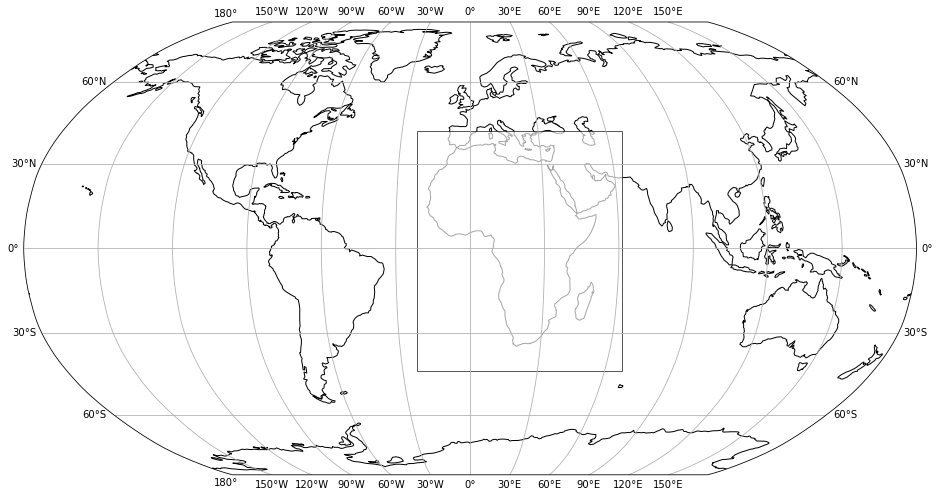

In [17]:

# all maps except distance to volcanoes
for i, row in obs.iterrows():

    region = 'World'
    
    obs_i = row['OBS_REF_IDW']
    #obs_i = row['OBS_REF_LN']
    
    #obs_r = row['OBS_REF_IDW']
    cmap_i = row['CMAPS']
    v_range_i = row['V_RANGE']
    label_i = row['LABELS']
    unit_i = row['UNITS']
    print(f'{obs_i} ..\n')
    
    if obs_i in ['VOLC_DIST_W']:
        continue

    
    fig, ax = plt.subplots(1, 1, figsize=fig_pres_large, 
                           subplot_kw={'projection': ccrs.Robinson()})

    #Make axis for inset colorbar
     
    ax.set_global()
    ax.coastlines()
    ax.gridlines(draw_labels=True, xlocs=np.arange(-180,180,30))

    plt.gca().add_patch(Rectangle(
        (0.44, 0.23), # lower left point of rectangle
        0.23, 0.53,   # width/height of rectangle
        transform=ax.transAxes,
        facecolor="white",
        edgecolor='black',
        alpha=0.65,
        zorder=2,
        ))


    sc = ax.imshow(grids[region].ds[obs_i]*grids[region].ds['LAND'], cmap=cmap_i, 
      alpha=0.5, extent=raster_extents[region],  
      vmin=v_range_i[0], vmax=v_range_i[1], transform=ccrs.PlateCarree())

    '''  
    ax.scatter(x= hf_dict[f'hf_best_{region}']['longitude'].values, 
    y = hf_dict[f'hf_best_{region}']['latitude'].values, 
    s=3, c=hf_dict[f'hf_best_{region}'][obs_i].values, marker='o', cmap=cmap_i, zorder=200,
    vmin=v_range_i[0], vmax=v_range_i[1], transform=ccrs.PlateCarree()) # edgecolors='k'''

     # position of zoomed in
    axins = ax.inset_axes([1.1, 0, 0.5,1])
    

    region ='Afr'  


    axins.imshow(grids[region].ds[obs_i]*grids[region].ds['LAND'], cmap=cmap_i, 
      alpha=0.5, extent=raster_extents[region],  
      vmin=v_range_i[0], vmax=v_range_i[1])

    x1, x2, y1, y2 = afr_lon_min, afr_lon_max, afr_lat_min,afr_lat_max

    axins.set_xlim(x1, x2)
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    ax.indicate_inset_zoom(axins, edgecolor="black")


    clb=plt.colorbar(sc, shrink=0.7,location='left')
    clb.set_label(unit_i,fontsize=15)
    clb.ax.tick_params(labelsize=13) 

  

# 2 - Merge data

get index from grid and distance and transfer it to training data

In [ ]:
# transfer obs values from grid to hf integrate grid index


training_f = dir_p /'data'/'dataset'/'Preprocessed'

hf_final_ra_copy = copy.deepcopy(hf_final_ra)
hf_final_rab_copy = copy.deepcopy(hf_final_rab)


region = 'World'

for hf_final,label in zip([hf_final_ra_copy, hf_final_rab_copy], ['ra_int.csv','rab_int.csv']):
    model_coords = np.stack([grids[region].lon.ravel(), grids[region].lat.ravel()], axis=-1) # lat and lon for all cells ravelled
    max_dist = np.sum(grids[region].res)/1.5 


    # stack coordin of best the good to compare to0 world grids[region]
    hf_coords = np.stack([hf_final['lon'], hf_final['lat']], axis=-1)
    # what is the index and distance of the neasrest points in world grids[region] to df
    grid_dists, indexs = spatial.KDTree(model_coords).query(hf_coords, 
                             distance_upper_bound=max_dist)
    hf_final.loc[:,'grid_index'] = indexs # This is the index to the cell in the ravel grids[region]


    dists_km = distance(hf_final['lat'].values, hf_final['lon'].values, 
                    grids[region].lat.ravel()[indexs],  grids[region].lon.ravel()[indexs])

    hf_final.loc[:,'dist_from_grid'] = dists_km*km


    for observable in list(grids[region].ds):
            hf_final.loc[:,observable] = grids[region].ds[observable].values.ravel()[hf_final.loc[:,'grid_index'].values] 
            

    '''
    hf_final_no_Afr = hf_final[~(hf_final['lon'].between(afr_lon_min, afr_lon_max)  
                    & hf_final['lat'].between(afr_lat_min, afr_lat_max))]
    hf_final_no_Aus = hf_final[~(hf_final['lon'].between(aus_lon_min, aus_lon_max)  
                    & hf_final['lat'].between(aus_lat_min, aus_lat_max))]


    local = '_Afr_'
    hf_final_no_Afr.sort_values(by=['lon', 'lat'], ascending=True, inplace=True)
    hf_final_no_Afr.reset_index( inplace=True,drop=True)
    hf_final_no_Afr.to_csv(training_f+local+label , index=False, header=True)

    local = '_Aus_'
    hf_final_no_Aus.sort_values(by=['lon', 'lat'], ascending=True, inplace=True)
    hf_final_no_Aus.reset_index( inplace=True,drop=True)
    hf_final_no_Aus.to_csv(training_f+local+label , index=False, header=True)
    ''' 

    local = 'W'
    hf_final.sort_values(by=['lon', 'lat'], ascending=True, inplace=True)
    hf_final.reset_index( inplace=True,drop=True)
    hf_final.to_csv(training_f/f'Training_{local}_{label}' , index=False, header=True)


print('terminated')

In [ ]:

hf_final_ra_copy = copy.deepcopy(hf_final_ra)
hf_final_rab_copy = copy.deepcopy(hf_final_rab)

region = 'World'

for hf_final,label in zip([hf_final_ra_copy, hf_final_rab_copy], ['W_merged_ra_int.csv','W_merged_rab_int.csv']):
    
    hf_final_Afr = hf_final[(hf_final['lon'].between(afr_lon_min, afr_lon_max)  
                    & hf_final['lat'].between(afr_lat_min, afr_lat_max))]
    

    
    region ='World'
    '''
    model_coords = np.stack([grids[region].lon.ravel(), grids[region].lat.ravel()], axis=-1) # lat and lon for all cells ravelled
    max_dist = np.sum(grids[region].res)/1.5 


    # stack coordin of best the good to compare to0 world grids[region]
    hf_coords = np.stack([hf_final['lon'], hf_final['lat']], axis=-1)
    # what is the index and distance of the neasrest points in world grids[region] to df
    grid_dists, indexs = spatial.KDTree(model_coords).query(hf_coords, 
                             distance_upper_bound=max_dist)
    hf_final.loc[:,'grid_index'] = indexs # This is the index to the cell in the ravel grids[region]


    dists_km = distance(hf_final['lat'].values, hf_final['lon'].values, 
                    grids[region].lat.ravel()[indexs],  grids[region].lon.ravel()[indexs])

    hf_final.loc[:,'dist_from_grid'] = dists_km*km'''

    
    for observable in list(grids[region].ds):
            hf_final.loc[:,observable] = grids[region].ds[observable].values.ravel()[hf_final.loc[:,'grid_index'].values] 
            
    #######

    
    
    region = 'Afr'
    
     # from grid afr take values into world
    model_coords = np.stack([grids[region].lon.ravel(), grids[region].lat.ravel()], axis=-1) # lat and lon for all cells ravelled
    max_dist = np.sum(grids[region].res)/1.5 


    # stack coordin of best the good to compare to0 world grids[region]
    hf_coords = np.stack([hf_final_Afr['lon'], hf_final_Afr['lat']], axis=-1)
    # what is the index and distance of the neasrest points in world grids[region] to df
    grid_dists, indexs = spatial.KDTree(model_coords).query(hf_coords, 
                             distance_upper_bound=max_dist)
    
    #modify grid index of world extracted africa with Africas
    hf_final_Afr.loc[:,'grid_index_afr'] = indexs # This is the index to the cell in the ravel grids[region]


    dists_km = distance(hf_final_Afr['lat'].values, hf_final_Afr['lon'].values, 
                    grids[region].lat.ravel()[indexs],  grids[region].lon.ravel()[indexs])

    #hf_final_Afr.loc[:,'dist_from_grid'] = dists_km*km
    
    #transfer value of africa into world
    for observable in list(grids[region].ds):
            hf_final_Afr.loc[:,observable] = grids[region].ds[observable].values.ravel()[hf_final_Afr.loc[:,'grid_index_afr'].values] 
    hf_final_Afr.drop(['grid_index_afr'], inplace=True, axis=1)
    
    
     #######
    
   
    ###### combine all aus and afr to world while keeping grid_index from world
  
    # remove aus afr values from world

    print(len(hf_final))
    hf_final_copy = hf_final[~(hf_final['lon'].between(afr_lon_min, afr_lon_max)  
                    & hf_final['lat'].between(afr_lat_min, afr_lat_max))]
    

    print(len(hf_final_copy))


    frames = [hf_final_copy,hf_final_Afr ]
    hf_final_copy = pd.concat(frames).reset_index(drop=True)

    print(len(hf_final_copy))
    

    hf_final_copy.sort_values(by=['lon', 'lat'], ascending=True, inplace=True)
    hf_final_copy.reset_index( inplace=True,drop=True)
    hf_final_copy.to_csv(training_f/f'Training_{label}' , index=False, header=True)
    



print('terminated')


In [ ]:

####


for hf_final,label in zip([hf_final_ra_copy, hf_final_rab_copy], ['ra_int.csv','rab_int.csv']):

    region = 'Afr'
    
    gt_afr_df = hf_final[(hf_final['lon'].between(afr_lon_min, afr_lon_max)  
                    & hf_final['lat'].between(afr_lat_min, afr_lat_max))].reset_index(drop=True)

    model_coords = np.stack([grids[region].lon.ravel(), grids[region].lat.ravel()], axis=-1) # lat and lon for all cells ravelled
    max_dist = np.sum(grids[region].res)/1.5 
    

    # stack coordin of best the good to compare to0 world grids[region]
    hf_coords = np.stack([gt_afr_df['lon'], gt_afr_df['lat']], axis=-1)
    # what is the index and distance of the neasrest points in world grids[region] to df
    grid_dists, indexs = spatial.KDTree(model_coords).query(hf_coords, 
                             distance_upper_bound=max_dist)
    gt_afr_df.loc[:,'grid_index'] = indexs # This is the index to the cell in the ravel grids[region]


    dists_km = distance(gt_afr_df['lat'].values, gt_afr_df['lon'].values, 
                    grids[region].lat.ravel()[indexs],  grids[region].lon.ravel()[indexs])

    gt_afr_df.loc[:,'dist_from_grid'] = dists_km*km
    
    for observable in list(grids[region].ds):
            gt_afr_df.loc[:,observable] = grids[region].ds[observable].values.ravel()[gt_afr_df.loc[:,'grid_index'].values] 
    
    
    gt_afr_df.sort_values(by=['lon', 'lat'], ascending=True, inplace=True)
    gt_afr_df.reset_index(drop=True, inplace=True)

    gt_afr_df.to_csv(training_f/f'Training_{region}_{label}' ,  index=False, header=True)


    ####
    region = 'Afr_50'
    
    gt_afr_df = hf_final[(hf_final['lon'].between(afr_lon_min, afr_lon_max)  
                    & hf_final['lat'].between(afr_lat_min, afr_lat_max))].reset_index(drop=True)

    model_coords = np.stack([grids[region].lon.ravel(), grids[region].lat.ravel()], axis=-1) # lat and lon for all cells ravelled
    max_dist = np.sum(grids[region].res)/1.5 
    

    # stack coordin of best the good to compare to0 world grids[region]
    hf_coords = np.stack([gt_afr_df['lon'], gt_afr_df['lat']], axis=-1)
    # what is the index and distance of the neasrest points in world grids[region] to df
    grid_dists, indexs = spatial.KDTree(model_coords).query(hf_coords, 
                             distance_upper_bound=max_dist)
    gt_afr_df.loc[:,'grid_index'] = indexs # This is the index to the cell in the ravel grids[region]


    dists_km = distance(gt_afr_df['lat'].values, gt_afr_df['lon'].values, 
                    grids[region].lat.ravel()[indexs],  grids[region].lon.ravel()[indexs])

    gt_afr_df.loc[:,'dist_from_grid'] = dists_km*km
    
    for observable in list(grids[region].ds):
            gt_afr_df.loc[:,observable] = grids[region].ds[observable].values.ravel()[gt_afr_df.loc[:,'grid_index'].values] 
    

    gt_afr_df.sort_values(by=['lon', 'lat'], ascending=True, inplace=True)
    gt_afr_df.reset_index(drop=True, inplace=True)

    gt_afr_df.to_csv(training_f/f'Training_{region}_{label}' ,  index=False, header=True)





print('terminated')


In [ ]:

####

hf_final_rabc_copy = copy.deepcopy(hf_final_rabc)
hf_final_rabcd_copy = copy.deepcopy(hf_final_rabcd)

for hf_final,label in zip([hf_final_rabc_copy, hf_final_rabcd_copy], ['rabc_int.csv','rabcd_int.csv']):

    region = 'Afr'
    
    gt_afr_df = hf_final[(hf_final['lon'].between(afr_lon_min, afr_lon_max)  
                    & hf_final['lat'].between(afr_lat_min, afr_lat_max))].reset_index(drop=True)

    model_coords = np.stack([grids[region].lon.ravel(), grids[region].lat.ravel()], axis=-1) # lat and lon for all cells ravelled
    max_dist = np.sum(grids[region].res)/1.5 
    

    # stack coordin of best the good to compare to0 world grids[region]
    hf_coords = np.stack([gt_afr_df['lon'], gt_afr_df['lat']], axis=-1)
    # what is the index and distance of the neasrest points in world grids[region] to df
    grid_dists, indexs = spatial.KDTree(model_coords).query(hf_coords, 
                             distance_upper_bound=max_dist)
    gt_afr_df.loc[:,'grid_index'] = indexs # This is the index to the cell in the ravel grids[region]


    dists_km = distance(gt_afr_df['lat'].values, gt_afr_df['lon'].values, 
                    grids[region].lat.ravel()[indexs],  grids[region].lon.ravel()[indexs])

    gt_afr_df.loc[:,'dist_from_grid'] = dists_km*km
    
    for observable in list(grids[region].ds):
            gt_afr_df.loc[:,observable] = grids[region].ds[observable].values.ravel()[gt_afr_df.loc[:,'grid_index'].values] 
    

    gt_afr_df.sort_values(by=['lon', 'lat'], ascending=True, inplace=True)
    gt_afr_df.reset_index(drop=True, inplace=True)

    gt_afr_df.to_csv(training_f/f'Training_{region}_{label}',  index=False, header=True)


    ####
    region = 'Afr_50'
    
    gt_afr_df = hf_final[(hf_final['lon'].between(afr_lon_min, afr_lon_max)  
                    & hf_final['lat'].between(afr_lat_min, afr_lat_max))].reset_index(drop=True)

    model_coords = np.stack([grids[region].lon.ravel(), grids[region].lat.ravel()], axis=-1) # lat and lon for all cells ravelled
    max_dist = np.sum(grids[region].res)/1.5 
    

    # stack coordin of best the good to compare to0 world grids[region]
    hf_coords = np.stack([gt_afr_df['lon'], gt_afr_df['lat']], axis=-1)
    # what is the index and distance of the neasrest points in world grids[region] to df
    grid_dists, indexs = spatial.KDTree(model_coords).query(hf_coords, 
                             distance_upper_bound=max_dist)
    gt_afr_df.loc[:,'grid_index'] = indexs # This is the index to the cell in the ravel grids[region]


    dists_km = distance(gt_afr_df['lat'].values, gt_afr_df['lon'].values, 
                    grids[region].lat.ravel()[indexs],  grids[region].lon.ravel()[indexs])

    gt_afr_df.loc[:,'dist_from_grid'] = dists_km*km
    
    for observable in list(grids[region].ds):
            gt_afr_df.loc[:,observable] = grids[region].ds[observable].values.ravel()[gt_afr_df.loc[:,'grid_index'].values] 
        

    gt_afr_df.sort_values(by=['lon', 'lat'], ascending=True, inplace=True)
    gt_afr_df.reset_index(drop=True, inplace=True)

    gt_afr_df.to_csv(training_f/f'Training_{region}_{label}' ,  index=False, header=True)





print('terminated')
